In [1]:
import collections
from datetime import datetime
import itertools
import logging
import multiprocessing
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import cwt, ricker, spectrogram
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from xgboost import XGBClassifier


tf.get_logger().setLevel(logging.ERROR)

# The Problem

The problem is described in detail [here](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones#).  30 subjects were instructed to perform  activities of daily living (ADL) such as walking, walking upstairs, walking downstairs, sitting, standing, and laying.  While performing these activities, the subjects were carrying a waist-mounted smartphone with embedded inertial sensors (accelerometers and gyroscopes).  Given both (a) time series data and (b) features extracted from the time series data, as recorded on the triaxial accelerometer and the triaxial gyroscope, classify the activity of the person wearing the sensors. 

The time series data is provided in the form of 9 text files: body_acc_x, body_acc_y, body_acc_z, body_gyro_x, body_gyro_y, body_gyro_z, total_acc_x, total_acc_y, total_acc_z. Each file for the training dataset contains 7352 recordings (rows) of 128 samples (columns) each.  Each file for the test dataset contains 2947 recordings (rows) of 128 samples (columns) each. 

The features extracted from the time series data are provided as 561 features (time and frequency domain) for each of the 7352 training recordings and 2947 test recordings.  

# General Approach and Results

**Solution 1**
Using the 561 extracted features for classification:
* Without dimensionality reduction: Three classifiers were compared on the basis of cross-validation (CV) accuracy on the training data set and test accuracy on the test dataset.  Logistic Regression was found to outperform Linear Discriminant Analysis and XGBoost classifiers.  The results were as follows: 

| Classifier | CV Accuracy | Test Accuracy | 
|------------|-------------|---------------|
| LogReg     | 93.65%      | 95.93%        |
| LDA        | 94.89%      | 89.68%        |
| XGBoost    | 92.45%      | 93.48%        |

* With dimensionality reduction: Since the number of features (561) is large, Principal Components Analysis was used to reduce the dimensionality from 561 features to 100, 200, 300, 400, and 500 features prior to using Logisitic Regression and XGBoost Classifiers.  The mean CV accuracy in each case was computed.  The mean CV accuracy score obtained for 300 components was comparable to the score obtained for 561 components when using Logistic Regression.  Similarly, the highest mean CV scores were obtained when using 300-400 components when using XGBoost classifier.   

**Solution 2**
Using the nine 128 sample raw time-traces for classification:
Deep neural networks were used. Three models were compared: 
* Model 1 (using time-domain signals alone): combination of CONV1D and bidirectional LSTM layers were used to process the time-domain signals
* Model 2 (using time-domain and frequency-domain signals):  In addition to the time-domain signal branch (same architecture as in Model 1), a combination of CONV2D and MaxPool2D layers were used to process the image obtained by concatenating the spectrograms (STFT) of the nine time-domain signals.
* Model 3 (using time-domain, frequency-domain, and wavelet-domain signals): In addition to the time-domain and frequency-domain signal branches (same architecture as in Model 2), a combination of CONV2D and MaxPool2D layers were used to process the image obtained by concatenating the wavelet spectra of the nine time-domain signals.

Model 3 outperformed Model 1 and Model 2 on the validation and test datasets.  The results were as follows: 

| Model      | Max Val Accuracy | Test Accuracy | 
|------------|------------------|---------------|
| Model 1  (CONV1D and LSTM on raw time-domain signals)  | 95.11%           | 84.66%        |
| Model 2  (Model 1 + CV techniques on spectrogram image)  | 96.19%           | 88.77%        |
| Model 3  (Model 2 + CV techniques on wavelet spectra image)  | 97.83%           | 95.01%        |

# Solution 1 : Using the extracted features for classification

In [2]:
X_train = pd.read_fwf('train/X_train.txt', header=None)
X_train.shape

(7352, 561)

In [3]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [4]:
feature_names = pd.read_fwf('features.txt', header=None)
feature_names.shape

(561, 1)

In [5]:
X_train.columns = feature_names[0]

In [6]:
X_train.head()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFre,553 fBodyBodyGyroJerkMag-skewnes,554 fBodyBodyGyroJerkMag-kurtosi,"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),grav","557 angle(tBodyGyroMean,gravityM","558 angle(tBodyGyroJerkMean,grav","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [7]:
y_train = pd.read_fwf('train/y_train.txt', header=None)
y_train.head()

,0
0,5
1,5
2,5
3,5
4,5


In [8]:
X_test = pd.read_fwf('test/X_test.txt', header=None)
X_test.columns = feature_names[0]

y_test = pd.read_fwf('test/y_test.txt', header=None)

In [10]:
ll_labels = ['walking', 'walking_up', 'walking_down', 'sitting', 'standing', 'laying']

### Applying Logistic Regression

In [15]:
clf_lr = LogisticRegression(max_iter=4000)

scores = cross_val_score(clf_lr, X_train, y_train[0], cv=5, scoring='accuracy')
print(scores)
print("Mean CV Accuracy: ", np.mean(scores))

[0.92454113 0.89530931 0.94557823 0.94965986 0.96734694]
Mean CV Accuracy:  0.936487095177976


In [12]:
clf_lr.fit(X_train, y_train[0])

LogisticRegression(max_iter=4000)

Accuracy on test dataset:  0.9592806243637597


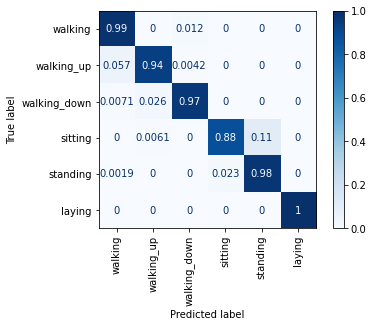

In [14]:
y_pred = clf_lr.predict(X_test)
accuracy = accuracy_score(y_test.values, y_pred)
print('Accuracy on test dataset: ', accuracy)
_ = plot_confusion_matrix(clf_lr, X_test, y_test, display_labels=ll_labels, xticks_rotation='vertical', cmap=plt.cm.Blues, normalize='true')

### PCA followed by Logistic Regression

In [17]:
scores = []
for n in [100, 200, 300, 400, 500, 561]:
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=n)), 
        ('clf', LogisticRegression(max_iter=4000))])

    scores.append(np.mean(cross_val_score(pipe, X_train, y_train[0], cv=5, scoring='accuracy')))



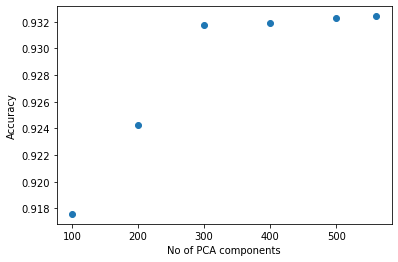

In [18]:
plt.scatter([100, 200, 300, 400, 500, 561], scores)
plt.xlabel('No of PCA components')
_ = plt.ylabel('Accuracy')

### Applying LDA

In [16]:
clf_lda = LinearDiscriminantAnalysis()
scores = cross_val_score(clf_lda, X_train, y_train[0], cv=5, scoring='accuracy')
print(scores)
print("Mean CV Accuracy: ", np.mean(scores))

[0.91910265 0.93405846 0.94897959 0.96326531 0.97891156]
Mean CV Accuracy:  0.9488635154945732


In [17]:
clf_lda.fit(X_train, y_train[0])

LinearDiscriminantAnalysis()

Accuracy on test dataset:  0.8968442483881914


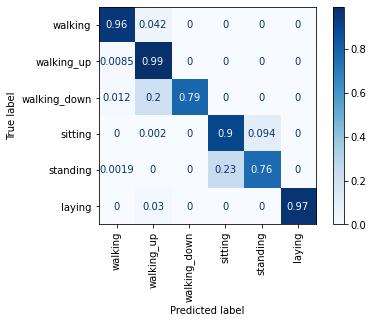

In [18]:
y_pred = clf_lda.predict(X_test)
accuracy = accuracy_score(y_test.values, y_pred)
print('Accuracy on test dataset: ', accuracy)
_ = plot_confusion_matrix(clf_lda, X_test, y_test, display_labels=ll_labels, xticks_rotation='vertical', cmap=plt.cm.Blues, normalize='true')

### Applying XGBoost Classifier

In [19]:
y_train_xgb = y_train[0] - 1
y_test_xgb = y_test[0] - 1

In [21]:
clf_xgb = XGBClassifier(booster='gbtree', max_depth=8, learning_rate=0.1, n_estimators=1000, use_label_encoder=False)

scores = cross_val_score(clf_xgb, X_train, y_train_xgb, cv=5, scoring='accuracy')
print(scores)
print("Mean CV Score: ", np.mean(scores))

[22:01:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:03:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [22]:
clf_xgb.fit(X_train, y_train_xgb)

[22:06:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

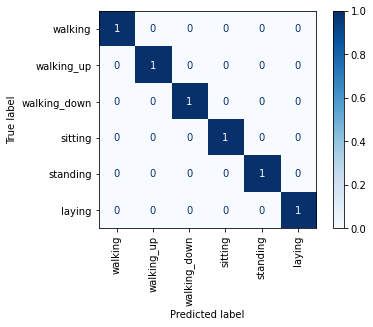

In [23]:
_ = plot_confusion_matrix(clf_xgb, X_train, y_train_xgb, display_labels=ll_labels, xticks_rotation='vertical', cmap=plt.cm.Blues, normalize='true')

Accuracy on test dataset:  0.9348489989820156


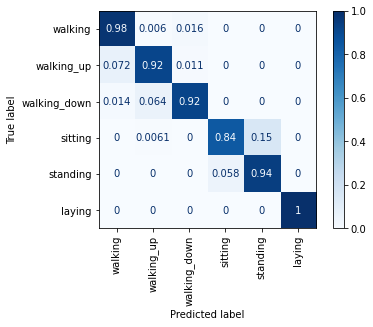

In [24]:
y_pred = clf_xgb.predict(X_test)
accuracy = accuracy_score(y_test_xgb, y_pred)
print('Accuracy on test dataset: ', accuracy)
_ = plot_confusion_matrix(clf_xgb, X_test, y_test_xgb, display_labels=ll_labels, xticks_rotation='vertical', cmap=plt.cm.Blues, normalize='true')

### PCA followed by XGBoost

In [29]:
scores = []
for n in [100, 200, 300, 400, 500, 561]:
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=n)), 
        ('clf', XGBClassifier(booster='gbtree', max_depth=8, learning_rate=0.1, n_estimators=1000, use_label_encoder=False))])

    scores.append(np.mean(cross_val_score(pipe, X_train, y_train_xgb, cv=5, scoring='accuracy')))



[19:58:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

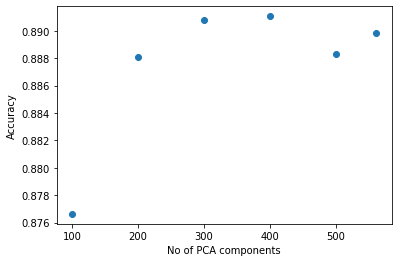

In [30]:
plt.scatter([100, 200, 300, 400, 500, 561], scores)
plt.xlabel('No of PCA components')
_ = plt.ylabel('Accuracy')

# Solution 2: Using the raw time domain signals for classification

### Deep Neural Networks on Raw Accel and Gyro Signals

In [2]:
dd_train = {
    'train_acc_x' : pd.read_fwf('train/Inertial Signals/body_acc_x_train.txt', header=None),
    'train_acc_y' : pd.read_fwf('train/Inertial Signals/body_acc_y_train.txt', header=None),
    'train_acc_z' : pd.read_fwf('train/Inertial Signals/body_acc_z_train.txt', header=None),
    'train_gyro_x' : pd.read_fwf('train/Inertial Signals/body_gyro_x_train.txt', header=None),
    'train_gyro_y' : pd.read_fwf('train/Inertial Signals/body_gyro_y_train.txt', header=None),
    'train_gyro_z' : pd.read_fwf('train/Inertial Signals/body_gyro_z_train.txt', header=None),
    'train_total_acc_x' : pd.read_fwf('train/Inertial Signals/total_acc_x_train.txt', header=None),
    'train_total_acc_y' : pd.read_fwf('train/Inertial Signals/total_acc_y_train.txt', header=None),
    'train_total_acc_z' : pd.read_fwf('train/Inertial Signals/total_acc_z_train.txt', header=None),
}

In [3]:
dd_test = {
    'test_acc_x' : pd.read_fwf('test/Inertial Signals/body_acc_x_test.txt', header=None),
    'test_acc_y' : pd.read_fwf('test/Inertial Signals/body_acc_y_test.txt', header=None),
    'test_acc_z' : pd.read_fwf('test/Inertial Signals/body_acc_z_test.txt', header=None),
    'test_gyro_x' : pd.read_fwf('test/Inertial Signals/body_gyro_x_test.txt', header=None),
    'test_gyro_y' : pd.read_fwf('test/Inertial Signals/body_gyro_y_test.txt', header=None),
    'test_gyro_z' : pd.read_fwf('test/Inertial Signals/body_gyro_z_test.txt', header=None),
    'test_total_acc_x' : pd.read_fwf('test/Inertial Signals/total_acc_x_test.txt', header=None),
    'test_total_acc_y' : pd.read_fwf('test/Inertial Signals/total_acc_y_test.txt', header=None),
    'test_total_acc_z' : pd.read_fwf('test/Inertial Signals/total_acc_z_test.txt', header=None),
}

#### Raw Time Series Signals 

In [4]:
def generate_time_series(idx, dd=dd_train, what='train'):
    time_series = []
    time_series.append(dd[f'{what}_acc_x'].loc[idx])
    time_series.append(dd[f'{what}_acc_y'].loc[idx])
    time_series.append(dd[f'{what}_acc_z'].loc[idx])
    time_series.append(dd[f'{what}_gyro_x'].loc[idx])
    time_series.append(dd[f'{what}_gyro_y'].loc[idx])
    time_series.append(dd[f'{what}_gyro_z'].loc[idx])
    time_series.append(dd[f'{what}_total_acc_x'].loc[idx])
    time_series.append(dd[f'{what}_total_acc_y'].loc[idx])
    time_series.append(dd[f'{what}_total_acc_z'].loc[idx])
    
    return np.array(time_series)

Activity : STANDING

In [5]:
ts_0 = generate_time_series(0, dd_train)
ts_0.shape

(9, 128)

In [86]:
y_train.loc[0, 0]   # Activity : STANDING

5

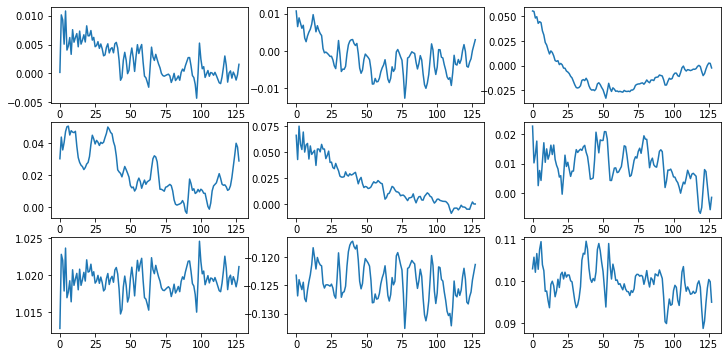

In [24]:
fig = plt.figure(figsize=(12,6))
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.plot(ts_0[n, :])

Activity : WALKING_UPSTAIRS

In [6]:
ts_500 = generate_time_series(500, dd_train)
ts_500.shape

(9, 128)

In [85]:
y_train.loc[500, 0]   # Activity : WALKING_UPSTAIRS

2

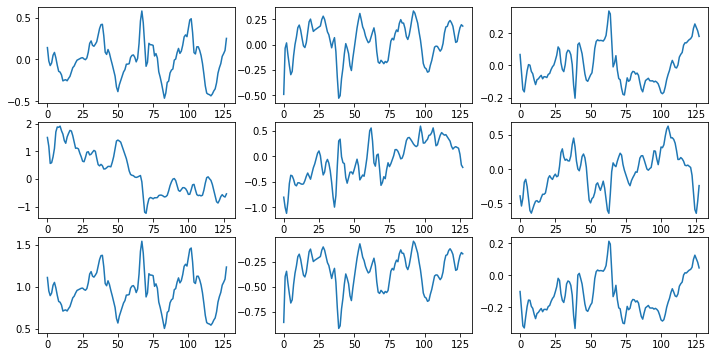

In [34]:
fig = plt.figure(figsize=(12,6))
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.plot(ts_500[n, :])

Activity : WALKING_DOWNSTAIRS

In [9]:
ts_140 = generate_time_series(140, dd_train)
y_train.loc[140, 0]   # Activity : WALKING_DOWNSTAIRS

3

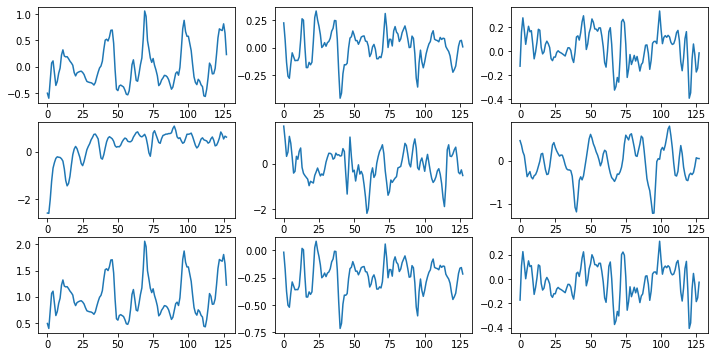

In [107]:
fig = plt.figure(figsize=(12,6))
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.plot(ts_140[n, :])

Activity: WALKING

In [10]:
ts_100 = generate_time_series(100, dd_train)
y_train.loc[100, 0]   # Activity : WALKING

1

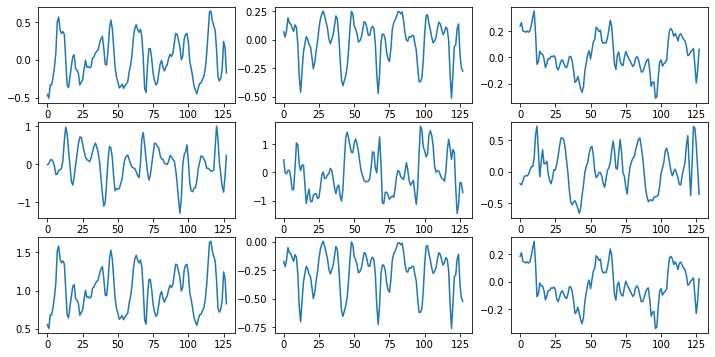

In [118]:
fig = plt.figure(figsize=(12,6))
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.plot(ts_100[n, :])

Activity: LAYING

In [11]:
ts_60 = generate_time_series(60, dd_train)
y_train.loc[60, 0]   # Activity : LAYING

6

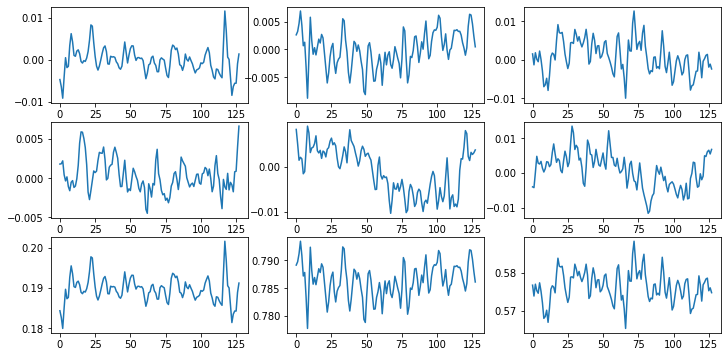

In [120]:
fig = plt.figure(figsize=(12,6))
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.plot(ts_60[n, :])

#### Frequency Domain Representation 

Activity : STANDING

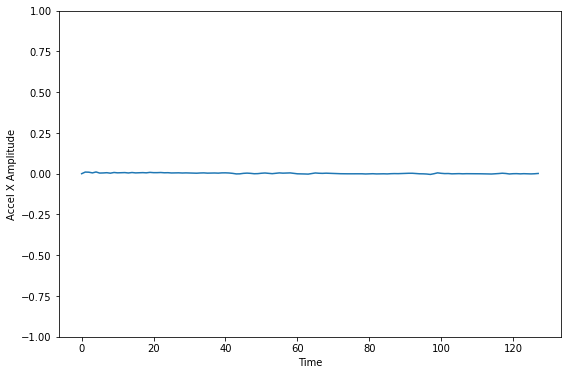

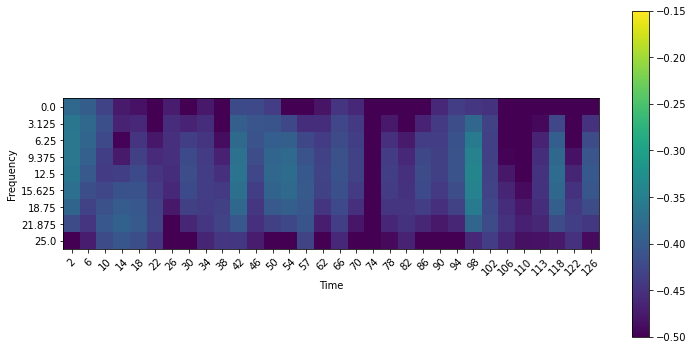

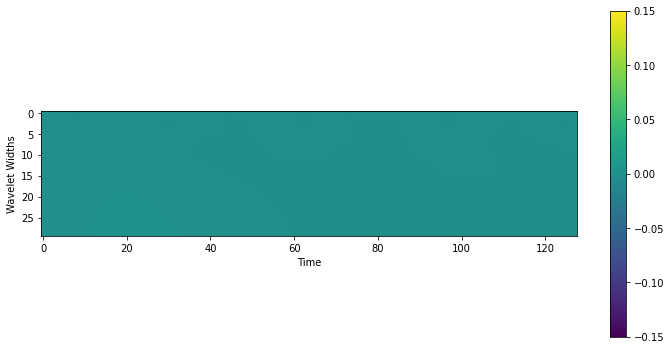

In [60]:
fig = plt.figure(figsize=(9, 6))
sig = ts_0[0, :]
plt.plot(sig)
plt.xlabel('Time')
plt.ylabel('Accel X Amplitude')
plt.ylim(-1, 1)

f, t, Sxx = spectrogram(sig, fs=50, nperseg=4, nfft=16)
fig = plt.figure(figsize=(12,6))
_ = plt.imshow(np.log(Sxx) / 40)
_ = plt.yticks(np.arange(len(f)), labels=f)
_ = plt.xticks(np.arange(len(t)), labels=[int(x*50) for x in t], rotation=45)
#plt.clim(-1, 0)
plt.clim(-0.5, -0.15)
plt.colorbar()
plt.xlabel('Time')
_ = plt.ylabel('Frequency')

widths = np.arange(1, 31)
sig_cwt = cwt(sig, ricker, widths) / 10
fig = plt.figure(figsize=(12,6))
_ = plt.imshow(sig_cwt)
#plt.clim(0, 0.2)
plt.clim(-0.15, 0.15)
plt.colorbar()
plt.xlabel('Time')
_ = plt.ylabel('Wavelet Widths')

Activity : WALKING_UPSTAIRS

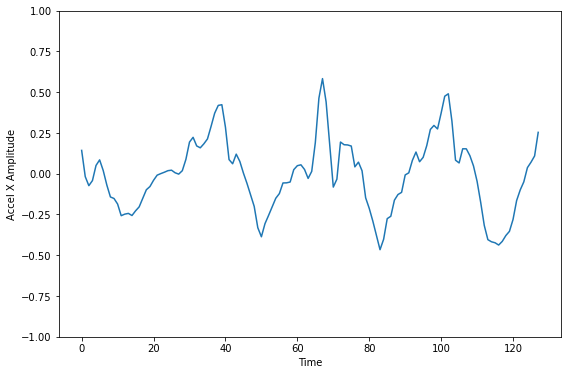

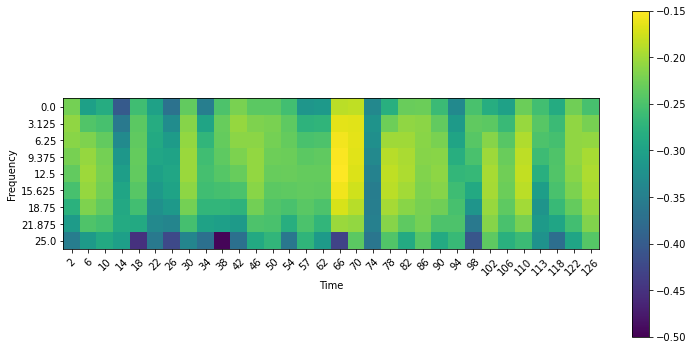

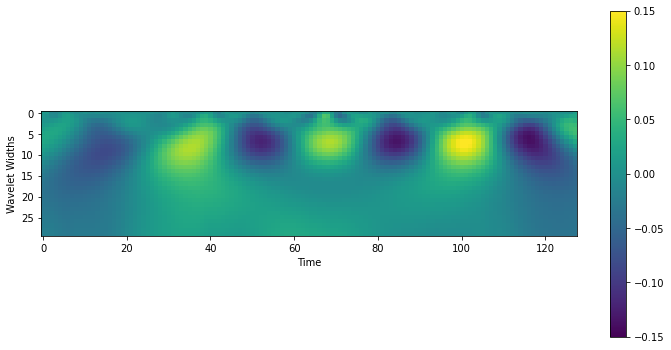

In [58]:
fig = plt.figure(figsize=(9, 6))
sig = ts_500[0, :]
plt.plot(sig)
plt.xlabel('Time')
plt.ylabel('Accel X Amplitude')
plt.ylim(-1, 1)

f, t, Sxx = spectrogram(sig, fs=50, nperseg=4, nfft=16)
fig = plt.figure(figsize=(12,6))
_ = plt.imshow(np.log(Sxx) / 40)
_ = plt.yticks(np.arange(len(f)), labels=f)
_ = plt.xticks(np.arange(len(t)), labels=[int(x*50) for x in t], rotation=45)
#plt.clim(-1, 0)
plt.clim(-0.5, -0.15)
plt.colorbar()
plt.xlabel('Time')
_ = plt.ylabel('Frequency')

widths = np.arange(1, 31)
sig_cwt = cwt(sig, ricker, widths) / 10
fig = plt.figure(figsize=(12,6))
_ = plt.imshow(sig_cwt)
#plt.clim(0, 0.2)
plt.clim(-0.15, 0.15)
plt.colorbar()
plt.xlabel('Time')
_ = plt.ylabel('Wavelet Widths')

In [33]:
ZERO_SUB = 1e-14
FS = 50
NPERSEG = 4
NFFT = 16
FD_SCALE = 40
WAVELET_SCALE = 10

def sub_zeros(sxx):
    sxx = sxx.copy()
    idx = np.where(sxx==0)[0]
    sxx[idx] = ZERO_SUB
    return sxx

def generate_spectrogram(idx, dd=dd_train, what='train', to_print=False):
    ts_idx = generate_time_series(idx, dd, what)
    spect_image = []
    for channel in range(9):
        sig = ts_idx[channel, :]
        f, t, Sxx = spectrogram(sig, fs=50, nperseg=4, nfft=16)
        Sxx = sub_zeros(Sxx)
        if to_print:
            plt.subplot(3, 3, channel+1)
            plt.imshow(Sxx)
        spect_image.append(np.log(Sxx) / FD_SCALE)
    spect_image_final = np.vstack(spect_image)
    
    return np.array(spect_image_final)

def generate_wavelet_matrix(idx, dd=dd_train, what='train', to_print=False):
    ts_idx = generate_time_series(idx, dd, what)
    cwt_image = []
    widths = np.arange(1, 31)
    for channel in range(9):
        sig = ts_idx[channel, :]
        sig_cwt = cwt(sig, ricker, widths) / WAVELET_SCALE 
        if to_print:
            plt.subplot(3, 3, channel+1)
            plt.imshow(sig_cwt, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto')
        cwt_image.append(sig_cwt)
    cwt_image_final = np.vstack(cwt_image)
    
    return np.array(cwt_image_final)

-0.724039450966574
-0.27706345892533213


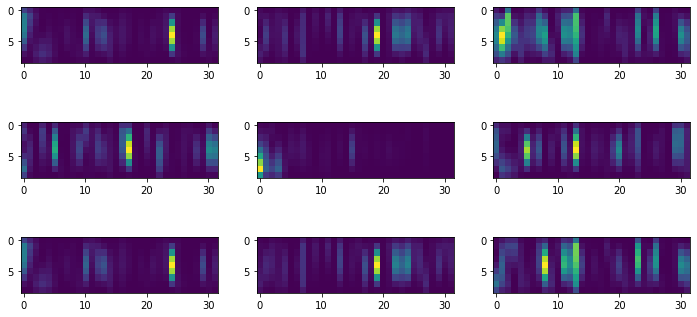

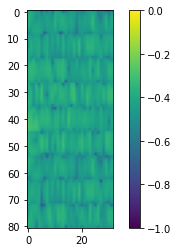

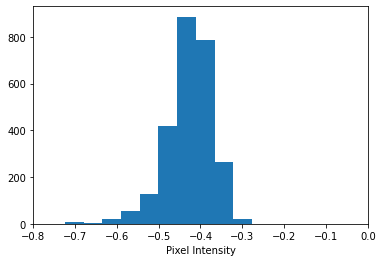

In [66]:
fig = plt.figure(figsize=(12,6))
img = generate_spectrogram(idx=0, dd=dd_train, to_print=True)

fig = plt.figure()
plt.imshow(img)
plt.clim(-1, 0)
plt.colorbar()

fig = plt.figure()
plt.hist(img.flatten())
plt.xlim([-0.8, 0])
plt.xlabel('Pixel Intensity')
print(np.min(img.flatten()))
print(np.max(img.flatten()))

-0.04975778712793032
0.3999667015136867


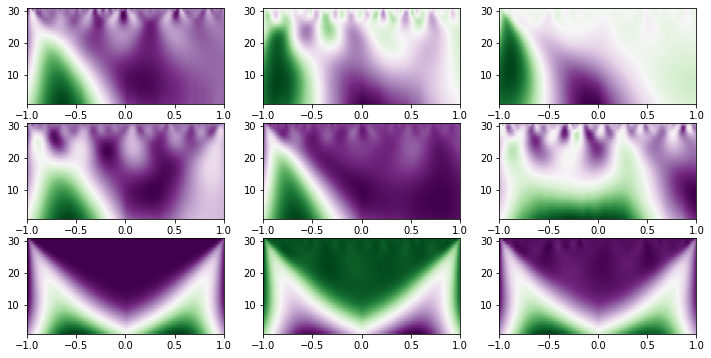

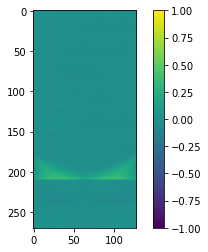

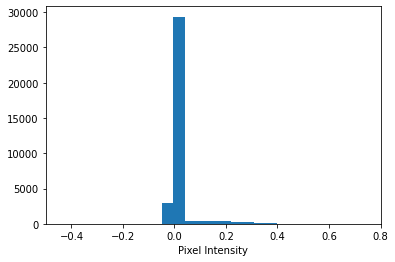

In [71]:
fig = plt.figure(figsize=(12,6))
img = generate_wavelet_matrix(idx=0, dd=dd_train, to_print=True)

fig = plt.figure()
plt.imshow(img)
plt.clim(-1, 1)
plt.colorbar()

fig = plt.figure()
plt.hist(img.flatten())
plt.xlim([-0.5, 0.8])
plt.xlabel('Pixel Intensity')
print(np.min(img.flatten()))
print(np.max(img.flatten()))

-0.6400923893846534
-0.10361939467607033


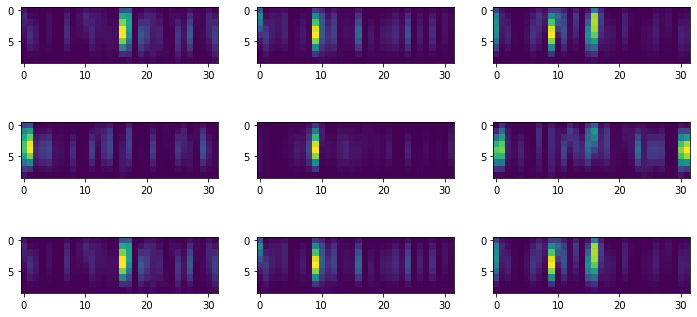

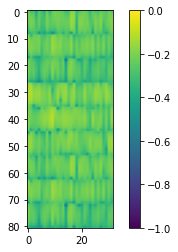

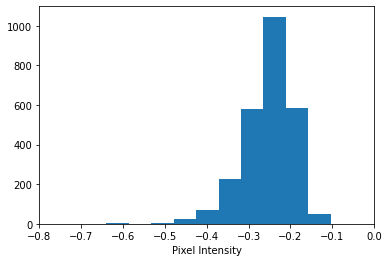

In [67]:
fig = plt.figure(figsize=(12,6))
img = generate_spectrogram(idx=500, dd=dd_train, to_print=True)

fig = plt.figure()
plt.imshow(img)
plt.clim(-1, 0)
plt.colorbar()

fig = plt.figure()
plt.hist(img.flatten())
plt.xlim([-0.8, 0])
plt.xlabel('Pixel Intensity')
print(np.min(img.flatten()))
print(np.max(img.flatten()))

-0.3830624336671159
0.6844999010570065


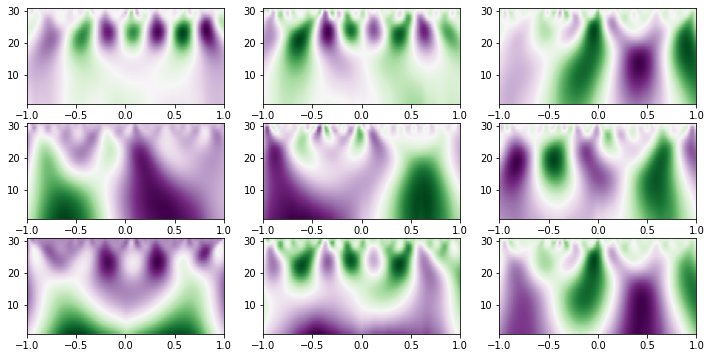

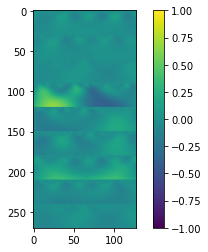

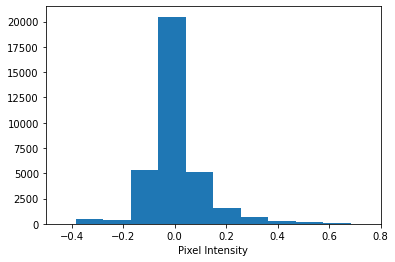

In [70]:
fig = plt.figure(figsize=(12,6))
img = generate_wavelet_matrix(idx=500, dd=dd_train, to_print=True)

fig = plt.figure()
plt.imshow(img)
plt.clim(-1, 1)
plt.colorbar()

fig = plt.figure()
plt.hist(img.flatten())
plt.xlim([-0.5, 0.8])
plt.xlabel('Pixel Intensity')

print(np.min(img.flatten()))
print(np.max(img.flatten()))

#### Adjust Labels (to range from 0 to 5, instead of 1 to 6)

In [39]:
y_train_adj = y_train[0] - 1
y_test_adj = y_test[0] - 1

#### Build Model

In [40]:
class DataGen(keras.utils.Sequence):
    
    def __init__(self, files, dd, what='train', batch_size=16, shuffle=True):
        self.what = what
        self.batch_size = batch_size
        self.dd = dd
        self.shuffle = shuffle
        self.all_files = files 
        if self.shuffle:
            random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        td_all = []
        fd_img_all = []
        wavelet_img_all = []
        
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            
            df_td = generate_time_series(file, self.dd, self.what)
            fd_img = generate_spectrogram(file, self.dd, self.what)
            cwt_img = generate_wavelet_matrix(file, self.dd, self.what)
            
            if self.what == 'train':
                label = y_train_adj.loc[file]
            else: 
                label = 0
            
            td_all.append(np.array(df_td))
            fd_img_all.append(np.expand_dims(fd_img, -1))
            wavelet_img_all.append(np.expand_dims(cwt_img, -1))
            
            y.append(label)
        
        return (np.array(td_all), np.array(fd_img_all), np.array(wavelet_img_all)), np.array(y)
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_files)

In [41]:
train_files, val_files = train_test_split(list(y_train.index), test_size=0.05)

In [42]:
train_gen = DataGen(train_files, dd_train, 'train', batch_size=16)
val_gen = DataGen(val_files, dd_train, 'train', batch_size=16)

In [43]:
x, y = train_gen[0]

print(x[0].shape)
print(x[1].shape)
print(x[2].shape)

print(y.shape)

(16, 9, 128)
(16, 81, 32, 1)
(16, 270, 128, 1)
(16,)


In [46]:
def build_model():
    td_inp = keras.Input(shape=(9, 128), name='td_inp')
    fd_inp = keras.Input(shape=(81, 32, 1), name='fd_inp')
    wavelet_inp = keras.Input(shape=(270, 128, 1), name='wavelet_inp')
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    time_output = layers.Dropout(0.2)(x)
    
    
    # Freq Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(fd_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x) 
    x = layers.Flatten()(x)
    freq_output = layers.Dropout(0.2)(x)
    
    
    # Wavelet Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(wavelet_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    wavelet_output = layers.Dropout(0.2)(x)
    
    concatenated = layers.concatenate([time_output, freq_output, wavelet_output], axis=-1)
    x = layers.Dense(128, activation='relu')(concatenated)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(6, activation='softmax')(x)
    
    
    model = keras.Model(inputs=[td_inp, fd_inp, wavelet_inp], outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [47]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wavelet_inp (InputLayer)        [(None, 270, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 268, 126, 32) 320         wavelet_inp[0][0]                
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 268, 63, 32)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 266, 61, 64)  18496       max_pooling2d_11[0][0]           
______________________________________________________________________________________________

In [48]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_full.h5', save_best_only=True, monitor='accuracy'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=30,
                    verbose=1,
                    validation_freq=10,
                    )
                    

Epoch 1/30
437/437 [==============================] - 150s 330ms/step - loss: 0.8612 - accuracy: 0.6195
Epoch 2/30
437/437 [==============================] - 145s 333ms/step - loss: 0.2151 - accuracy: 0.9141
Epoch 3/30
437/437 [==============================] - 145s 332ms/step - loss: 0.1569 - accuracy: 0.9387
Epoch 4/30
437/437 [==============================] - 145s 332ms/step - loss: 0.1335 - accuracy: 0.9445
Epoch 5/30
437/437 [==============================] - 146s 334ms/step - loss: 0.1142 - accuracy: 0.9510
Epoch 6/30
437/437 [==============================] - 144s 330ms/step - loss: 0.0989 - accuracy: 0.9613
Epoch 7/30
437/437 [==============================] - 145s 331ms/step - loss: 0.0866 - accuracy: 0.9646
Epoch 8/30
437/437 [==============================] - 145s 333ms/step - loss: 0.0798 - accuracy: 0.9698
Epoch 9/30
437/437 [==============================] - 145s 332ms/step - loss: 0.0678 - accuracy: 0.9724
Epoch 10/30
437/437 [==============================] - 155s 354m

Max Validation Accuracy:  0.97826087474823


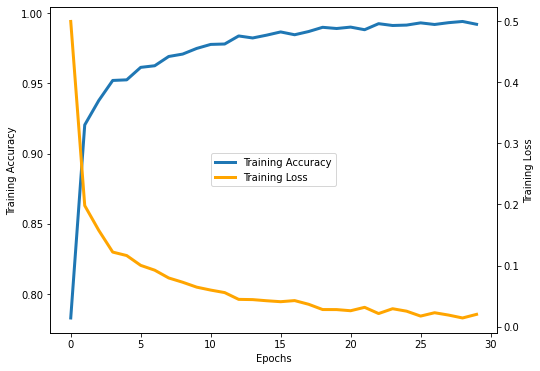

In [78]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

#### Inference

In [62]:
model = keras.models.load_model('keya_model_full.h5')

In [63]:
test_files = y_test.index
no_of_test_files = len(test_files)
test_gen = DataGen(test_files, dd_test, 'test', batch_size=10, shuffle=False)


In [64]:
BATCH_SIZE = 10

y_final = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_one_hot = model.predict(test_gen[batch][0])
    y_final.extend(np.argmax(y_final_one_hot, axis=1))

In [65]:
accuracy = accuracy_score(y_test_adj, y_final)
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.9501187648456056


Confusion Matrix: 
[[0.96572581 0.00201613 0.03225806 0.         0.         0.        ]
 [0.04670913 0.91932059 0.02972399 0.00424628 0.         0.        ]
 [0.01904762 0.01190476 0.96904762 0.         0.         0.        ]
 [0.         0.00203666 0.         0.92668024 0.0712831  0.        ]
 [0.         0.         0.         0.08082707 0.91917293 0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


<AxesSubplot:>

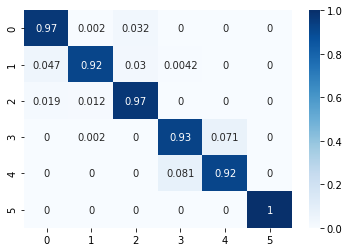

In [66]:
cm = confusion_matrix(y_test_adj, y_final, normalize='true')
print("Confusion Matrix: ")
print(cm)
sns.heatmap(cm, cmap='Blues', annot=True)

Labels for the confusion matrix are: 0: 'walking', 1: 'walking_upstairs', 2: 'walking_downstairs', 3: 'sitting', 4: 'standing', 5: 'laying'

### Using Time Domain Only 

In [79]:
class DataGen_TD(keras.utils.Sequence):
    
    def __init__(self, files, dd, what='train', batch_size=16, shuffle=True):
        self.what = what
        self.batch_size = batch_size
        self.dd = dd
        self.shuffle = shuffle
        self.all_files = files 
        if self.shuffle:
            random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        td_all = []
        
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            
            df_td = generate_time_series(file, self.dd, self.what)
            
            if self.what == 'train':
                label = y_train_adj.loc[file]
            else: 
                label = 0
            
            td_all.append(np.array(df_td))
            
            y.append(label)
        
        return np.array(td_all), np.array(y)
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_files)

In [80]:
train_files, val_files = train_test_split(list(y_train.index), test_size=0.05)

In [81]:
train_gen = DataGen_TD(train_files, dd_train, 'train', batch_size=16)
val_gen = DataGen_TD(val_files, dd_train, 'train', batch_size=16)

In [84]:
def build_model_td():
    td_inp = keras.Input(shape=(9, 128), name='td_inp')
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(6, activation='softmax')(x)
    
    
    model = keras.Model(inputs=td_inp, outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [85]:
model = build_model_td()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
td_inp (InputLayer)          [(None, 9, 128)]          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 64)             57408     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 3, 128)            66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1651

In [86]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_td.h5', save_best_only=True, monitor='accuracy'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=30,
                    verbose=1,
                    validation_freq=10,
                    )

Epoch 1/30
437/437 [==============================] - 11s 16ms/step - loss: 1.3867 - accuracy: 0.4606
Epoch 2/30
437/437 [==============================] - 7s 17ms/step - loss: 0.5634 - accuracy: 0.7607
Epoch 3/30
437/437 [==============================] - 7s 16ms/step - loss: 0.4078 - accuracy: 0.8374
Epoch 4/30
437/437 [==============================] - 7s 17ms/step - loss: 0.3543 - accuracy: 0.8689
Epoch 5/30
437/437 [==============================] - 7s 16ms/step - loss: 0.3031 - accuracy: 0.8867
Epoch 6/30
437/437 [==============================] - 7s 16ms/step - loss: 0.2585 - accuracy: 0.9020
Epoch 7/30
437/437 [==============================] - 7s 17ms/step - loss: 0.2109 - accuracy: 0.9220
Epoch 8/30
437/437 [==============================] - 7s 16ms/step - loss: 0.1913 - accuracy: 0.9242
Epoch 9/30
437/437 [==============================] - 7s 16ms/step - loss: 0.1635 - accuracy: 0.9344
Epoch 10/30
437/437 [==============================] - 8s 19ms/step - loss: 0.1539 - accur

Max Validation Accuracy:  0.9510869383811951


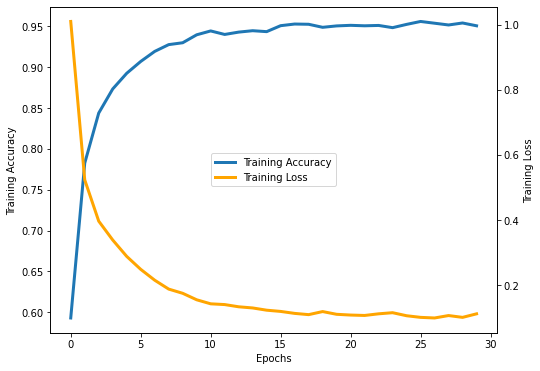

In [87]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

#### Inference

In [88]:
model = keras.models.load_model('keya_model_td.h5')

In [89]:
test_files = y_test.index
no_of_test_files = len(test_files)
test_gen = DataGen_TD(test_files, dd_test, 'test', batch_size=10, shuffle=False)

In [90]:
BATCH_SIZE = 10

y_final = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_one_hot = model.predict(test_gen[batch][0])
    y_final.extend(np.argmax(y_final_one_hot, axis=1))

In [91]:
accuracy = accuracy_score(y_test_adj, y_final)
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.8466236851034951


### Using Time Domain and Frequency Domain (but no Wavelet Domain)

In [92]:
class DataGen_TD_FD(keras.utils.Sequence):
    
    def __init__(self, files, dd, what='train', batch_size=16, shuffle=True):
        self.what = what
        self.batch_size = batch_size
        self.dd = dd
        self.shuffle = shuffle
        self.all_files = files 
        if self.shuffle:
            random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        td_all = []
        fd_img_all = []
        
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            
            df_td = generate_time_series(file, self.dd, self.what)
            fd_img = generate_spectrogram(file, self.dd, self.what)
            
            
            if self.what == 'train':
                label = y_train_adj.loc[file]
            else: 
                label = 0
            
            td_all.append(np.array(df_td))
            fd_img_all.append(np.expand_dims(fd_img, -1))
    
            
            y.append(label)
        
        return (np.array(td_all), np.array(fd_img_all)), np.array(y)
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_files)

In [93]:
train_files, val_files = train_test_split(list(y_train.index), test_size=0.05)

In [94]:
train_gen = DataGen_TD_FD(train_files, dd_train, 'train', batch_size=16)
val_gen = DataGen_TD_FD(val_files, dd_train, 'train', batch_size=16)

In [95]:
def build_model_td_fd():
    td_inp = keras.Input(shape=(9, 128), name='td_inp')
    fd_inp = keras.Input(shape=(81, 32, 1), name='fd_inp')
   
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    time_output = layers.Dropout(0.2)(x)
    
    
    # Freq Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(fd_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    freq_output = layers.Dropout(0.2)(x)
    
    concatenated = layers.concatenate([time_output, freq_output], axis=-1)
    x = layers.Dense(128, activation='relu')(concatenated)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(6, activation='softmax')(x)
    
    
    model = keras.Model(inputs=[td_inp, fd_inp], outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['accuracy'],
    )
    
    return model

In [97]:
model = build_model_td_fd()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fd_inp (InputLayer)             [(None, 81, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 79, 30, 32)   320         fd_inp[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 79, 15, 32)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 77, 13, 64)   18496       max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [98]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_td_fd.h5', save_best_only=True, monitor='accuracy'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=30,
                    verbose=1,
                    validation_freq=10,
                    )

Epoch 1/30
437/437 [==============================] - 30s 60ms/step - loss: 1.3119 - accuracy: 0.4159
Epoch 2/30
437/437 [==============================] - 27s 61ms/step - loss: 0.5595 - accuracy: 0.7356
Epoch 3/30
437/437 [==============================] - 26s 61ms/step - loss: 0.4307 - accuracy: 0.8092
Epoch 4/30
437/437 [==============================] - 27s 61ms/step - loss: 0.3315 - accuracy: 0.8764
Epoch 5/30
437/437 [==============================] - 26s 61ms/step - loss: 0.2473 - accuracy: 0.9052
Epoch 6/30
437/437 [==============================] - 26s 60ms/step - loss: 0.2009 - accuracy: 0.9235
Epoch 7/30
437/437 [==============================] - 27s 61ms/step - loss: 0.1640 - accuracy: 0.9357
Epoch 8/30
437/437 [==============================] - 27s 61ms/step - loss: 0.1517 - accuracy: 0.9414
Epoch 9/30
437/437 [==============================] - 27s 61ms/step - loss: 0.1356 - accuracy: 0.9442
Epoch 10/30
437/437 [==============================] - 29s 66ms/step - loss: 0.119

Max Validation Accuracy:  0.9619565010070801


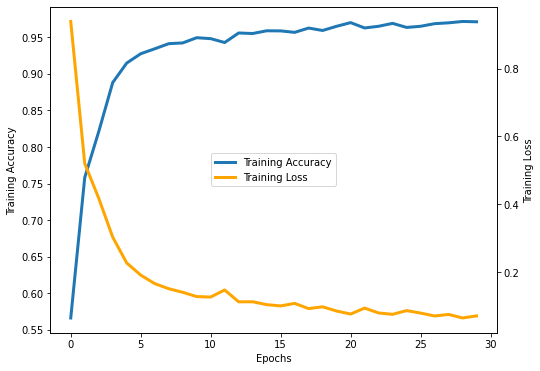

In [99]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

lns1 = ax1.plot(history.history['accuracy'], lw=3, label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Accuracy')

lns2 = ax2.plot(history.history['loss'], color='orange', lw=3, label='Training Loss')
ax2.set_ylabel('Training Loss')

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='center')

print("Max Validation Accuracy: ", np.max(history.history['val_accuracy']))

#### Inference 

In [100]:
model = keras.models.load_model('keya_model_td_fd.h5')

In [101]:
test_files = y_test.index
no_of_test_files = len(test_files)
test_gen = DataGen_TD_FD(test_files, dd_test, 'test', batch_size=10, shuffle=False)

In [102]:
BATCH_SIZE = 10

y_final = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_one_hot = model.predict(test_gen[batch][0])
    y_final.extend(np.argmax(y_final_one_hot, axis=1))

In [103]:
accuracy = accuracy_score(y_test_adj, y_final)
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.8876823888700374
